# 🧠 Feature Vectors & Embeddings - Practical Introduction

This notebook builds intuition for representing data (numbers, text) as vectors, measuring similarity (cosine, distance), and eventually using modern embeddings.

**1‑Hour Session Flow (today's focus):**

0. Setup & goals
1. From tabular data to vectors (geometry & distance)
2. Bag‑of‑Words (BoW) – sparse text vectors & limitations
3. Enter dense embeddings 
4. Enter cosine similarity

> We’ll add semantic / transformer embeddings after validating the early sections. Feel free to edit narrative tone.

---
### ✅ Learning Goals (for first pass)
- See any data row as a numeric vector
- Compute & interpret cosine similarity
- Convert short texts into BoW vectors
- Visualize vectors in 2D (PCA) & observe clustering
- Understand limitations of sparse representations


## 0. Setup & Imports
We'll start with a lightweight set of dependencies already in the project (pandas, numpy, scikit-learn, seaborn, matplotlib). No heavyweight embedding models yet.

Run the next cell to import utilities.

In [13]:
# Core imports for vector operations & visualization
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (7,4)

print("✅ Imports ready")

✅ Imports ready


## 1. From Tabular Data to Vectors
Goal: Connect something already familiar (tabular ML features) with the idea of *vectors in space*.

We will:
1. Create a tiny synthetic dataset (like toy house listings)
2. Standardize numeric features to comparable scale
3. Treat each row as a vector and compute distances / cosine similarity
4. Visualize in 2D using PCA

> Mental model: each data point = coordinate in multi‑dimensional space. Closeness ≈ similarity (with caveats about scaling & metric choice).

In [27]:
# Create a tiny synthetic tabular dataset (house-like features)
raw = pd.DataFrame({
    'rooms': [3, 4, 2, 5, 4, 3],
    'size_m2': [70, 95, 55, 140, 100, 75],
    'age_years': [30, 5, 45, 2, 12, 28],
    'distance_to_center_km': [8.0, 4.0, 12.0, 3.0, 5.0, 7.5],
    'price_k': [210, 360, 150, 560, 390, 240]
})

raw.head(6)

,rooms,size_m2,age_years,distance_to_center_km,price_k
0,3,70,30,8.0,210
1,4,95,5,4.0,360
2,2,55,45,12.0,150
3,5,140,2,3.0,560
4,4,100,12,5.0,390
5,3,75,28,7.5,240


In [ ]:

features = ['rooms','size_m2','age_years','distance_to_center_km','price_k']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(raw[features])

print("First vector (raw):", raw[features].iloc[0].values)
print("First vector (scaled):", np.round(X_scaled[0], 3))

First vector (raw): [  3.  70.  30.   8. 210.]
First vector (scaled): [-0.522 -0.702  0.633  0.471 -0.795]



2D PCA visualization of the tabular vectors (scaled):


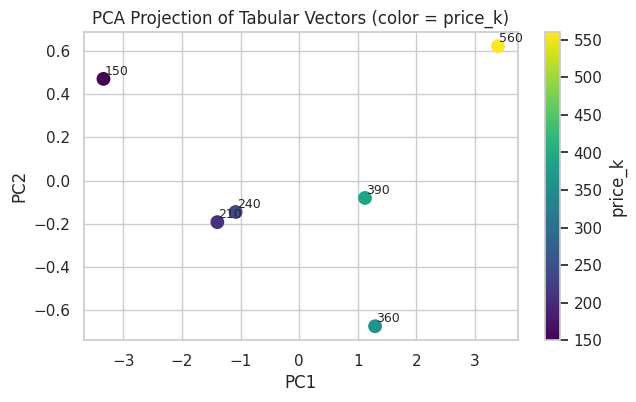

In [16]:
# 2D visualization with PCA (just for intuition)
print("\n2D PCA visualization of the tabular vectors (scaled):")
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

fig, ax = plt.subplots()
scatter = ax.scatter(coords[:,0], coords[:,1], c=raw['price_k'], cmap='viridis', s=80)
for i, price in enumerate(raw['price_k']):
    ax.annotate(str(price), (coords[i,0]+0.02, coords[i,1]+0.02), fontsize=9)

ax.set_title('PCA Projection of Tabular Vectors (color = price_k)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
cb = plt.colorbar(scatter)
cb.set_label('price_k')
plt.show()

In [17]:
# Explain the dimensionality of vectors in our tabular data

print("🔍 Understanding Vector Dimensionality\n")

print("1. What is dimensionality?")
print("   - Each feature becomes one dimension in vector space")
print("   - Our dataset has", len(features), "features, so each data point is a", len(features), "dimensional vector")
print("   - Features:", features)

print("\n2. Raw vs Scaled vectors:")
print("   Raw vector (house 0):", raw[features].iloc[0].values)
print("   Scaled vector (house 0):", np.round(X_scaled[0], 3))
print("   → Same dimensionality (", len(features), "D), but scaled values are comparable")

print("\n3. Vector space interpretation:")
print("   - Each house = one point in 5D space")
print("   - Distance between points = similarity between houses")
print("   - Cannot visualize 5D directly → use PCA to project to 2D")

print("\n4. Dimensionality comparison:")
print(f"   - Original data: {raw[features].shape[0]} houses × {raw[features].shape[1]} dimensions")
print(f"   - PCA projection: {coords.shape[0]} houses × {coords.shape[1]} dimensions (lossy compression)")
print(f"   - Information retained by 2D PCA: {sum(pca.explained_variance_ratio_):.1%}")

print("\n5. Why dimensionality matters:")
print("   - High dimensions = curse of dimensionality (distances become less meaningful)")
print("   - Low dimensions = easier to visualize but lose information")
print("   - Text data will have MUCH higher dimensionality (vocabulary size)")

🔍 Understanding Vector Dimensionality

1. What is dimensionality?
   - Each feature becomes one dimension in vector space
   - Our dataset has 5 features, so each data point is a 5 dimensional vector
   - Features: ['rooms', 'size_m2', 'age_years', 'distance_to_center_km', 'price_k']

2. Raw vs Scaled vectors:
   Raw vector (house 0): [  3.  70.  30.   8. 210.]
   Scaled vector (house 0): [-0.522 -0.702  0.633  0.471 -0.795]
   → Same dimensionality ( 5 D), but scaled values are comparable

3. Vector space interpretation:
   - Each house = one point in 5D space
   - Distance between points = similarity between houses
   - Cannot visualize 5D directly → use PCA to project to 2D

4. Dimensionality comparison:
   - Original data: 6 houses × 5 dimensions
   - PCA projection: 6 houses × 2 dimensions (lossy compression)
   - Information retained by 2D PCA: 99.7%

5. Why dimensionality matters:
   - High dimensions = curse of dimensionality (distances become less meaningful)
   - Low dimensio

### 🔍 Reflection
- Each row became a **vector** after scaling.
- PCA gave a lossy 2D view; proximity there roughly reflects multi-dimensional similarity.

> If something felt unclear, add a note now before we proceed to text.

## 2. Bag-of-Words (BoW): Text → Sparse Vectors
We now turn short texts into vectors using vocabulary counts.

Steps:
1. Build a mini corpus
2. Tokenize & build vocabulary
3. Create count matrix (documents × vocabulary)
4. Compare documents (cosine similarity)
5. Reduce & visualize
6. Note limitations (synonyms, sparsity, order ignorance)


In [18]:
# Mini corpus (short, varied topics)
corpus = [
    "Dogs love playing in sunny parks",
    "Puppies enjoy fun sunny walks",
    "Stock markets fell after economic report",
    "Investors fear market volatility and risk",
    "Cats prefer quiet shaded gardens",
    "Economic growth reports boosted investor optimism",
    "Canines really like playful outdoor activities",
    "Market turbulence increases investor caution",
    "Solar energy adoption is accelerating worldwide",
    "Kittens often enjoy quiet garden spaces",
]

# Basic tokenization (lowercase + split). For pedagogy (not production!)
import re

def tokenize(text):
    return re.findall(r"[a-zA-Z]+", text.lower())

tokenized = [tokenize(doc) for doc in corpus]

# Build vocabulary
from collections import Counter
vocab_counter = Counter(token for doc in tokenized for token in doc)
vocab = sorted(vocab_counter)  # alphabetical for reproducibility
idx = {w:i for i,w in enumerate(vocab)}

# Build count matrix
matrix = np.zeros((len(corpus), len(vocab)), dtype=int)
for doc_i, doc in enumerate(tokenized):
    for token in doc:
        matrix[doc_i, idx[token]] += 1

bow_df = pd.DataFrame(matrix, columns=vocab)
print("Vocabulary size:", len(vocab))
print("BoW shape:", bow_df.shape)

# display full dataframe width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
bow_df.head()

Vocabulary size: 51
BoW shape: (10, 51)


,accelerating,activities,adoption,after,and,boosted,canines,cats,caution,dogs,economic,energy,enjoy,fear,fell,fun,garden,gardens,growth,in,increases,investor,investors,is,kittens,like,love,market,markets,often,optimism,outdoor,parks,playful,playing,prefer,puppies,quiet,really,report,reports,risk,shaded,solar,spaces,stock,sunny,turbulence,volatility,walks,worldwide
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [19]:
# Show individual vectors
# make sure notebook output cell does not truncate or move long lines to next line
# not related to pandas display settings

print("First vector: ", bow_df.iloc[0].values[:35])
print("Second vector:", bow_df.iloc[1].values[:35])
print("Third vector: ", bow_df.iloc[2].values[:35])
print("Forth vector: ", bow_df.iloc[3].values[:35])
print("Fifth vector: ", bow_df.iloc[4].values[:35])

First vector:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1]
Second vector: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Third vector:  [0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Forth vector:  [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
Fifth vector:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


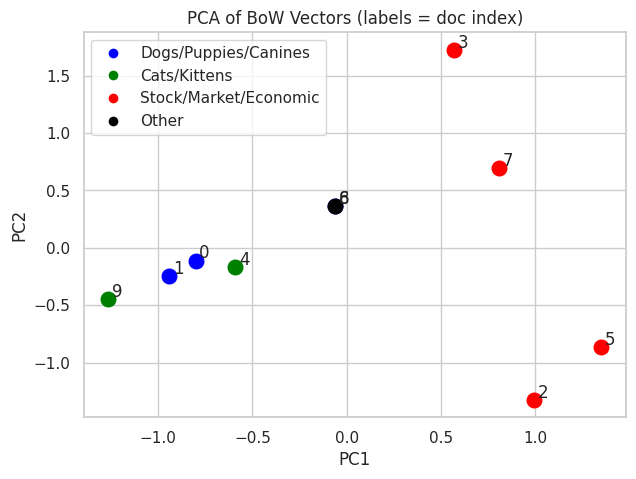

0: Dogs love playing in sunny parks
1: Puppies enjoy fun sunny walks
2: Stock markets fell after economic report
3: Investors fear market volatility and risk
4: Cats prefer quiet shaded gardens
5: Economic growth reports boosted investor optimism
6: Canines really like playful outdoor activities
7: Market turbulence increases investor caution
8: Solar energy adoption is accelerating worldwide
9: Kittens often enjoy quiet garden spaces


In [20]:
from matplotlib.lines import Line2D

# Visualize BoW vectors in 2D (PCA)
pca_bow = PCA(n_components=2, random_state=42)
coords_bow = pca_bow.fit_transform(bow_df.values)

plt.figure(figsize=(7,5))

# Define colors for different categories
colors_bow = []
for i, sentence in enumerate(corpus):
    sentence_lower = sentence.lower()
    if any(word in sentence_lower for word in ['dog', 'puppies', 'canine']):
        colors_bow.append('blue')    # dogs/puppies/canines
    elif any(word in sentence_lower for word in ['kitten', 'cat']):
        colors_bow.append('green')   # cats/kittens
    elif any(word in sentence_lower for word in ['stock', 'market', 'investor', 'economic']):
        colors_bow.append('red')     # stock market related
    else:
        colors_bow.append('black')   # everything else

for i, (x, y) in enumerate(coords_bow):
    plt.scatter(x, y, color=colors_bow[i], s=110)
    plt.annotate(str(i), (x+0.02, y+0.02))

plt.title('PCA of BoW Vectors (labels = doc index)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
legend_elements_bow = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Dogs/Puppies/Canines'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Cats/Kittens'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Stock/Market/Economic'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Other')]
plt.legend(handles=legend_elements_bow, loc='best')
plt.show()

for i, doc in enumerate(corpus):
    print(f"{i}: {doc}")

### 🔍 BoW Reflection & Limitations
**What worked:**
- Simple to implement & fast for small corpora
- Captures word presence & rough topical similarity

**Limitations:**
- Treats words as independent (order ignored)
- Vocabulary growth → very high dimensional sparse vectors
- Synonyms not linked ("dogs" vs "puppies" partly overlap only by shared words like *love* if present)
- Rare words overweighted; common words might dominate unless reweighted (→ TF‑IDF)

> Next: move to **dense embeddings** that place semantically similar texts *closer* even without shared surface tokens.

## 3. Enter Embeddings: Dense Semantic Vectors
Sparse BoW vectors rely on exact token overlap. **Embeddings** map text to a dense, low(er)-dimensional space where *semantic* closeness (meaning) is reflected by vector proximity.

### Key Differences vs BoW
| Aspect | BoW / Counts | Dense Embeddings |
|--------|--------------|------------------|
| Dimensionality | Vocabulary size (hundreds–millions) | Fixed (e.g. 384 / 768) |
| Sparsity | Mostly zeros | Fully dense |
| Synonyms | Far apart (no shared tokens) | Close (context learned) |
| Word order | Ignored (basic BoW) | Captured (contextual models) |
| OOV Handling | Fails/ignores | Subwords or character pieces |

We'll use a lightweight **Sentence Transformer** (MiniLM) to produce sentence-level embeddings for the same corpus plus some semantically related and unrelated sentences.

> If the library isn't installed, the next code cell will attempt to install it automatically.

In [21]:
# Install sentence-transformers if missing (lightweight model)
import importlib, sys, subprocess
from sentence_transformers import SentenceTransformer


model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
print(f"Loaded model: {model_name}")

semantic_corpus = corpus 

embeddings = model.encode(semantic_corpus, normalize_embeddings=True)
print("Embeddings shape:", embeddings.shape)
print("First vector (truncated):", np.round(embeddings[0][:10], 3), '...')

Loaded model: sentence-transformers/all-MiniLM-L6-v2
Embeddings shape: (10, 384)
First vector (truncated): [ 0.023 -0.052  0.068  0.054 -0.007  0.032  0.099 -0.067  0.041  0.043] ...


### Inspecting Semantic Similarity
Above we used a pre-trained MiniLM model to embed each sentence and then performed a cosine similarity lookup.

Key observations you should see:
- Synonyms / paraphrases ("Dogs love playing in the park" vs "Canines really like going to parks") rank highly.
- The stock market sentences cluster separately from the animal sentences.
- Unrelated sentences (e.g., about kittens vs stock markets) have noticeably lower scores.
- This worked even though some words are not identical (dog vs canines, playing vs going to).

Why cosine similarity? Because embedding vectors are length-normalized; cosine focuses on orientation (semantic direction) rather than raw magnitude.

Next we will: (a) visualize the dense embedding space vs earlier BoW/PCA, (b) compare rankings with a TF-IDF baseline, and (c) build a tiny semantic search function.


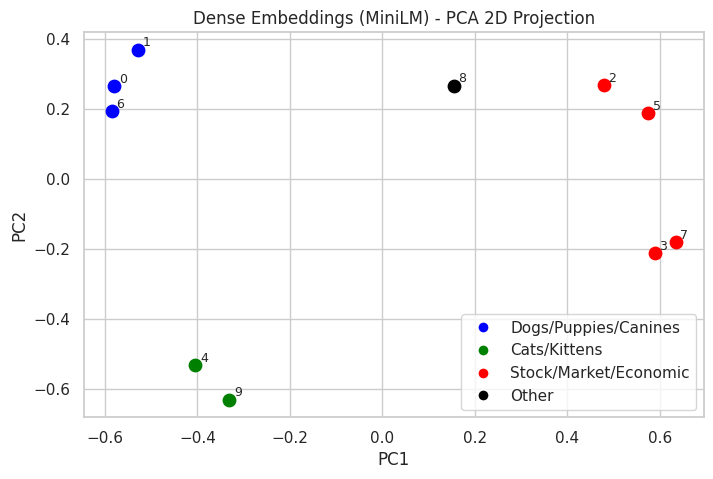

Index to sentence mapping:
0: Dogs love playing in sunny parks
1: Puppies enjoy fun sunny walks
2: Stock markets fell after economic report
3: Investors fear market volatility and risk
4: Cats prefer quiet shaded gardens
5: Economic growth reports boosted investor optimism
6: Canines really like playful outdoor activities
7: Market turbulence increases investor caution
8: Solar energy adoption is accelerating worldwide
9: Kittens often enjoy quiet garden spaces


In [22]:
# 3.3 Visualize dense embeddings (PCA)

pca2 = PCA(n_components=2, random_state=42)
emb_2d = pca2.fit_transform(embeddings)

plt.figure(figsize=(8,5))

# Define colors for different categories
colors = []
for i, sentence in enumerate(semantic_corpus):
    sentence_lower = sentence.lower()
    if any(word in sentence_lower for word in ['dog', 'puppies', 'canine', 'kitten', 'cat']):
        if any(word in sentence_lower for word in ['kitten', 'cat']):
            colors.append('green')  # cats/kittens
        else:
            colors.append('blue')    # dogs/puppies/canines
    elif any(word in sentence_lower for word in ['stock', 'market', 'investor', 'economic']):
        colors.append('red')         # stock market related
    else:
        colors.append('black')       # everything else

for i, (x, y) in enumerate(emb_2d):
    plt.scatter(x, y, color=colors[i], s=80)
    plt.text(x+0.01, y+0.01, str(i), fontsize=9)

plt.title('Dense Embeddings (MiniLM) - PCA 2D Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Dogs/Puppies/Canines'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Cats/Kittens'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Stock/Market/Economic'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Other')]
plt.legend(handles=legend_elements, loc='best')
plt.show()

print("Index to sentence mapping:")
for i, s in enumerate(semantic_corpus):
    print(f"{i}: {s}")


### Reflection: Dense vs BoW Spaces
Compare this plot with the earlier BoW PCA projection:

- BoW relied on raw token overlap; semantically close sentences with different surface forms (dog/canine, playing/going) could appear farther apart.
- Dense embeddings compress multi-word semantics into directions so paraphrases cluster more tightly.
- High-dimensional geometry means some separation may not fully appear in a 2D PCA slice; UMAP (if installed) can sometimes reveal clearer groupings.
- Small corpora can yield unstable projections; with more sentences, thematic clusters (pets, finance, weather, travel) become more distinct.

Takeaway: Dense models capture meaning beyond literal word overlap, enabling better retrieval and clustering.


## 4. Enter Cosine Similarity

Now that we have dense embeddings for our corpus, we need a way to measure how similar different sentences are to each other. **Cosine similarity** is the most common choice for comparing embedding vectors.

#### Why Cosine Similarity?

**Cosine similarity** measures the angle between two vectors, focusing on their *direction* rather than magnitude. For normalized embeddings (like ours from MiniLM), this captures semantic orientation:

- **Range**: -1 (opposite directions) to +1 (same direction)
- **Interpretation**: Higher values = more semantically similar
- **Advantage**: Scale-invariant (sentence length doesn't dominate)

#### Alternative Distance Metrics

While cosine similarity is standard for embeddings, other metrics exist:

| Metric | Formula            | Best For | Limitation |
|--------|--------------------|----------|------------|
| **Cosine Similarity** | cos(θ) = A·B / (\|\|A\|\| \|\|B\|\|) | Normalized embeddings | Ignores magnitude (sentence length) |
| **Euclidean Distance** | √Σ(ai - bi)² | Raw feature vectors | Sensitive to scale |
| **Manhattan Distance** | Σ\|ai - bi\| | Sparse vectors | Less smooth |
| **Dot Product** | A·B | When magnitude (sentence length) matters | Scale-dependent |


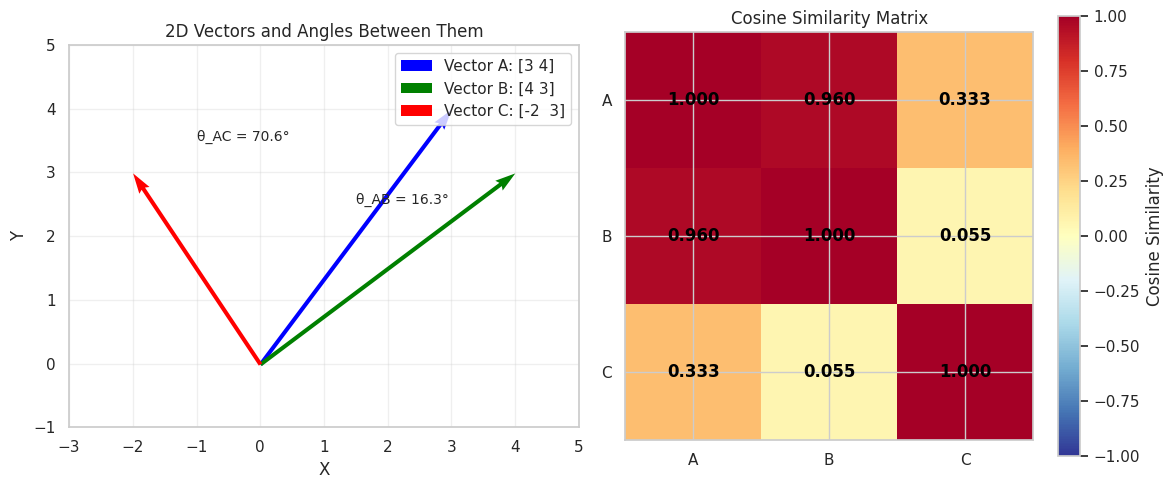

🔍 Understanding Cosine Similarity with Simple 2D Vectors

Vector definitions:
  Vector A: [3 4] (pointing northeast)
  Vector B: [4 3] (pointing northeast, similar to A)
  Vector C: [-2  3] (pointing northwest, different from A & B)

Cosine similarities:
  A ↔ B: 0.960 (small angle = high similarity)
  A ↔ C: 0.333 (large angle = low similarity)
  B ↔ C: 0.055 (medium angle = medium similarity)

Key insights:
  • Cosine similarity = 1.0 when vectors point in exactly the same direction
  • Cosine similarity = 0.0 when vectors are perpendicular (90° angle)
  • Cosine similarity = -1.0 when vectors point in opposite directions
  • The actual length (magnitude) of vectors doesn't matter!

Why cosine similarity works for embeddings:
  • Embeddings capture semantic 'direction' in high-dimensional space
  • Similar meanings point in similar directions
  • Different meanings point in different directions
  • We care about orientation, not magnitude (sentence length)


In [23]:
# Simple visual explanation of cosine similarity using 2D vectors

# Create simple 2D vectors for easy visualization
vec_a = np.array([3, 4])  # Vector pointing northeast
vec_b = np.array([4, 3])  # Vector pointing northeast (similar direction)
vec_c = np.array([-2, 3]) # Vector pointing northwest (different direction)

# Calculate cosine similarities
def cosine_sim_2d(v1, v2):
    """Calculate cosine similarity between two 2D vectors"""
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    return dot_product / (magnitude_v1 * magnitude_v2)

cos_ab = cosine_sim_2d(vec_a, vec_b)
cos_ac = cosine_sim_2d(vec_a, vec_c)
cos_bc = cosine_sim_2d(vec_b, vec_c)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Vector visualization
origin = np.array([0, 0])
ax1.quiver(*origin, *vec_a, angles='xy', scale_units='xy', scale=1, color='blue', width=0.008, label=f'Vector A: {vec_a}')
ax1.quiver(*origin, *vec_b, angles='xy', scale_units='xy', scale=1, color='green', width=0.008, label=f'Vector B: {vec_b}')
ax1.quiver(*origin, *vec_c, angles='xy', scale_units='xy', scale=1, color='red', width=0.008, label=f'Vector C: {vec_c}')

# Draw angle arcs (simplified representation)
theta_a = np.arctan2(vec_a[1], vec_a[0])
theta_b = np.arctan2(vec_b[1], vec_b[0])
theta_c = np.arctan2(vec_c[1], vec_c[0])

# Add angle annotations
ax1.annotate(f'θ_AB = {np.degrees(abs(theta_a - theta_b)):.1f}°', xy=(1.5, 2.5), fontsize=10)
ax1.annotate(f'θ_AC = {np.degrees(abs(theta_a - theta_c)):.1f}°', xy=(-1, 3.5), fontsize=10)

ax1.set_xlim(-3, 5)
ax1.set_ylim(-1, 5)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.legend()
ax1.set_title('2D Vectors and Angles Between Them')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Plot 2: Cosine similarity heatmap
vectors = [vec_a, vec_b, vec_c]
labels = ['A', 'B', 'C']
similarity_matrix = np.array([
    [1.0, cos_ab, cos_ac],
    [cos_ab, 1.0, cos_bc],
    [cos_ac, cos_bc, 1.0]
])

im = ax2.imshow(similarity_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax2.set_xticks(range(3))
ax2.set_yticks(range(3))
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)

# Add text annotations
for i in range(3):
    for j in range(3):
        text = ax2.text(j, i, f'{similarity_matrix[i, j]:.3f}', 
                       ha="center", va="center", color="black", fontweight='bold')

ax2.set_title('Cosine Similarity Matrix')
plt.colorbar(im, ax=ax2, label='Cosine Similarity')

plt.tight_layout()
plt.show()

# Print explanations
print("🔍 Understanding Cosine Similarity with Simple 2D Vectors\n")

print("Vector definitions:")
print(f"  Vector A: {vec_a} (pointing northeast)")
print(f"  Vector B: {vec_b} (pointing northeast, similar to A)")
print(f"  Vector C: {vec_c} (pointing northwest, different from A & B)")

print(f"\nCosine similarities:")
print(f"  A ↔ B: {cos_ab:.3f} (small angle = high similarity)")
print(f"  A ↔ C: {cos_ac:.3f} (large angle = low similarity)")
print(f"  B ↔ C: {cos_bc:.3f} (medium angle = medium similarity)")

print(f"\nKey insights:")
print("  • Cosine similarity = 1.0 when vectors point in exactly the same direction")
print("  • Cosine similarity = 0.0 when vectors are perpendicular (90° angle)")
print("  • Cosine similarity = -1.0 when vectors point in opposite directions")
print("  • The actual length (magnitude) of vectors doesn't matter!")

print(f"\nWhy cosine similarity works for embeddings:")
print("  • Embeddings capture semantic 'direction' in high-dimensional space")
print("  • Similar meanings point in similar directions")
print("  • Different meanings point in different directions")
print("  • We care about orientation, not magnitude (sentence length)")

In [24]:
# import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix for embeddings
emb_cos = cosine_similarity(embeddings)

import numpy as np

# Helper: show top-k similar sentences for a query index
def show_top_k(idx, k=5):
    scores = emb_cos[idx]
    ranked = np.argsort(-scores)
    print(f"\nQuery [{idx}]: {semantic_corpus[idx]}")
    print("Top matches:")
    for r in ranked[1:k+1]:  # skip self
        print(f"  • ({r}) score={scores[r]:.3f} :: {semantic_corpus[r]}")

# Demonstrate for a few queries
show_top_k(0)   # dogs
show_top_k(4)   # stock markets
show_top_k(3)  # last added (kittens / gardens)


Query [0]: Dogs love playing in sunny parks
Top matches:
  • (6) score=0.677 :: Canines really like playful outdoor activities
  • (1) score=0.673 :: Puppies enjoy fun sunny walks
  • (4) score=0.458 :: Cats prefer quiet shaded gardens
  • (9) score=0.287 :: Kittens often enjoy quiet garden spaces
  • (8) score=0.151 :: Solar energy adoption is accelerating worldwide

Query [4]: Cats prefer quiet shaded gardens
Top matches:
  • (9) score=0.718 :: Kittens often enjoy quiet garden spaces
  • (0) score=0.458 :: Dogs love playing in sunny parks
  • (6) score=0.448 :: Canines really like playful outdoor activities
  • (1) score=0.318 :: Puppies enjoy fun sunny walks
  • (8) score=0.124 :: Solar energy adoption is accelerating worldwide

Query [3]: Investors fear market volatility and risk
Top matches:
  • (7) score=0.676 :: Market turbulence increases investor caution
  • (5) score=0.399 :: Economic growth reports boosted investor optimism
  • (2) score=0.269 :: Stock markets fell after ec

In [25]:
# compare with BoW cosine similarity
bow_cos = cosine_similarity(bow_df.values)
print("\nBoW Cosine Similarity Matrix (first 5 rows):\n", np.round(bow_cos[:5,:5], 3))
print("\nDense Embeddings Cosine Similarity Matrix (first 5 rows):\n", np.round(emb_cos[:5,:5], 3))


BoW Cosine Similarity Matrix (first 5 rows):
 [[1.    0.183 0.    0.    0.   ]
 [0.183 1.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    1.   ]]

Dense Embeddings Cosine Similarity Matrix (first 5 rows):
 [[ 1.     0.673 -0.008 -0.036  0.458]
 [ 0.673  1.     0.038 -0.025  0.318]
 [-0.008  0.038  1.     0.269 -0.034]
 [-0.036 -0.025  0.269  1.     0.079]
 [ 0.458  0.318 -0.034  0.079  1.   ]]
